In [1]:
"""
This file is from https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#overview-of-audio-features

"""
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.13.1
0.13.1


In [2]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

- Wavform

- Raw Spectrogram(complex-valued)

- Power Spectrogram(real-valued)

- Mel-scale spectrogram

- MFCC

- LFCC

- Pitch

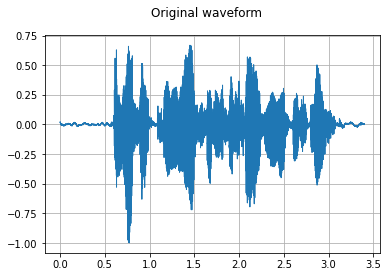

In [3]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform")
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

## Spectrogram

In [4]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [5]:
# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

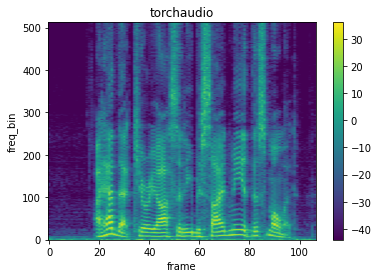

In [6]:
plot_spectrogram(spec[0], title="torchaudio")

## GriffinLim (Power spectrogram to Wavform)

1. Spectrogram 

2. random phase 

3. iter

    - istft
    
    - stft
    
    - angle = angle - prev*momentum
    
    - update prev 

4. istft (Spectrogram * angle)

In [7]:
torch.random.manual_seed(0)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(SPEECH_WAVEFORM)

In [8]:
griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

In [9]:
reconstructed_waveform = griffin_lim(spec)

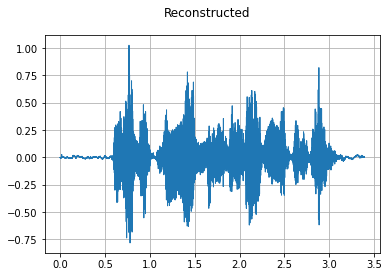

In [10]:
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed")
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

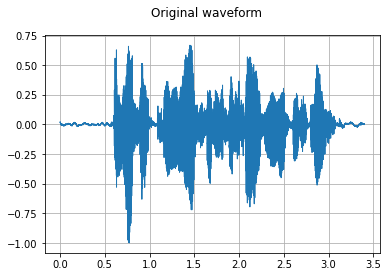

In [11]:
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform")

## Mel filter Bank

In [12]:
n_fft = 256
n_mels = 64
sample_rate = 6000

"""TODO
mel = 
melscale: frequency bin per mel
- htk
    
    mel = 2595.0 * math.log10(1.0 + (freq / 700.0))

    freq = 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

- slaney(norm): "slaney", divide the triangular mel weights by the width of the mel band (area normalization)
    
    mel = [TODO]
                        fb 
    -------------------------------------------
      f_pts[2 : n_mels + 2] - f_pts[:n_mels]
      --------------------------------------
                        2


"""
mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
    mel_scale="htk"
    # mel_scale="slaney"
)

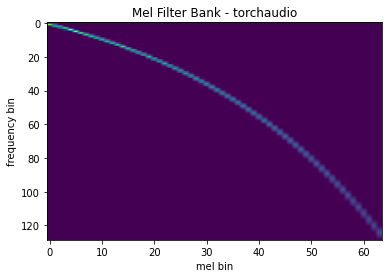

In [13]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

In [14]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

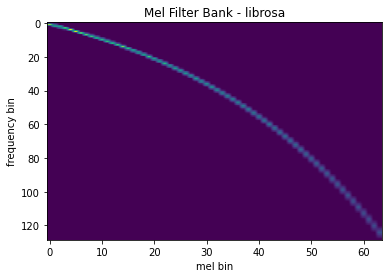

Mean Square Difference:  5.326851900683876e-17


In [15]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

## Mel-Spectrogram

In [16]:
"""
norm slaney vs None
mel_scale htk vs slaney
"""
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    # norm=None,
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
    # mel_scale="slaney",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

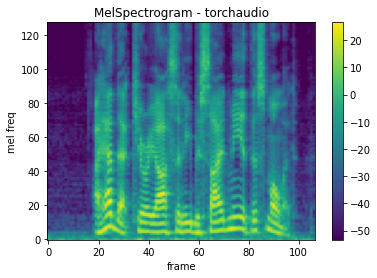

In [17]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [18]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

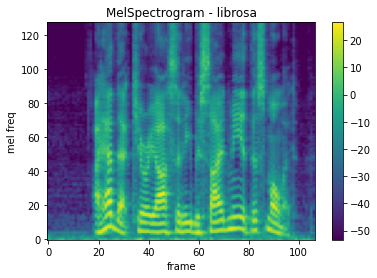

Mean Square Difference:  1.0319716192697115e-09


In [19]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MFCC

mel -> log-mel -> dct -> mfcc

In [20]:
# [TODO] top_db

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

In [31]:
mfcc[0].shape

torch.Size([256, 107])

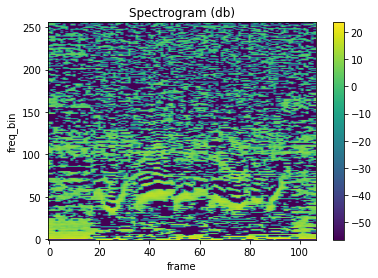

In [21]:
plot_spectrogram(mfcc[0])

In [22]:
 # [TODO] norm = ortho means ortho-normal DCT basis
# lifter: emphasizes the higher-order coefficients
# M[n, :] <- M[n, :] * (1 + sin(pi * (n + 1) / lifter) * lifter / 2)

melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

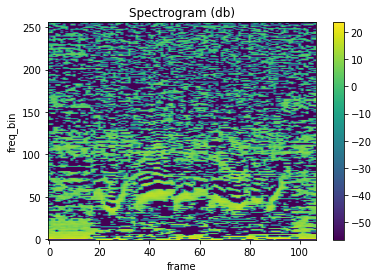

Mean Square Difference:  0.810394287109375


In [23]:
plot_spectrogram(mfcc_librosa)

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

## LFCC

spectrogram -> linear-filter bank -> log -> dct -> mfcc

In [24]:
n_fft = 256

linear_filters = F.linear_fbanks(
    n_freqs=(n_fft // 2 + 1),
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    n_filter=128
)

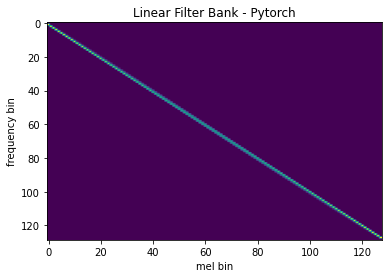

In [25]:
plot_fbank(linear_filters, "Linear Filter Bank - Pytorch")

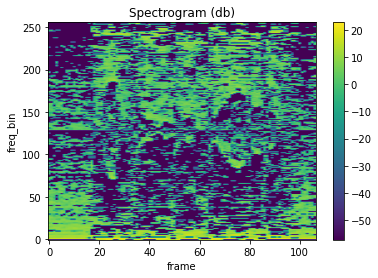

In [26]:
"""
DB-scaled linear filtered spectrogram

"""

n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0])

## Pitch

Normalized Cross-Correlation Function -> max per frame -> median smoothing

In [27]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

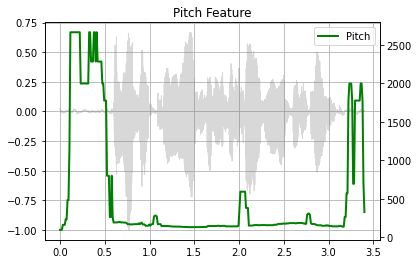

In [28]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)

In [29]:
# [TODO] What is nfcc?
## Kaldi Pitch

# A pitch extraction algorithm tuned for automatic speech recognition
# Ghahremani, B. BabaAli, D. Povey, K. Riedhammer, J. Trmal and S. Khudanpur
# 2014 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Florence, 2014, pp. 2494-2498, doi: 10.1109/ICASSP.2014.6854049. [abstract], [paper]
pitch_feature = F.compute_kaldi_pitch(SPEECH_WAVEFORM, SAMPLE_RATE)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

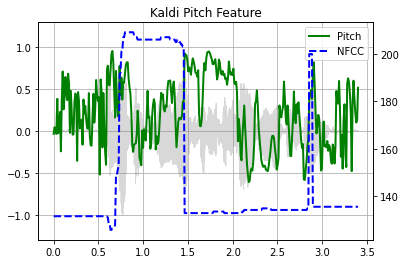

In [30]:
def plot_kaldi_pitch(waveform, sr, pitch, nfcc):
    _, axis = plt.subplots(1, 1)
    axis.set_title("Kaldi Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")
    axis.set_ylim((-1.3, 1.3))

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, nfcc.shape[1])
    ln2 = axis2.plot(time_axis, nfcc[0], linewidth=2, label="NFCC", color="blue", linestyle="--")

    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    axis.legend(lns, labels, loc=0)
    plt.show(block=False)


plot_kaldi_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch, nfcc)